<a href="https://colab.research.google.com/github/RanaAyman/MagicGamma_DataClassification/blob/main/MagicGamma_DataClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement** <br>
Given the MAGIC gamma telescope dataset that can be obtained using this Link. This dataset
is generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. The dataset consists of two
classes; gammas (signal) and hadrons (background). There are 12332 gamma events and 6688
hadron events. You are required to use this dataset to apply different classification models
such as Decision Trees, Na¨ıve Bayes Classifier, Random Forests, AdaBoost and KNearest Neighbor (K-NN). You are also required to tune the parameters of these models,
and compare the performance of models with each other.

In [ ]:
import random
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [ ]:
max_accuracy = [] #to store accuracy of each algorithm to comapare between their results

In [ ]:
def read(): return pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data',sep=',', header=None)

The dataset is class-imbalanced. To balance the dataset, randomly put aside
the extra readings for the gamma “g” class to make both classes equal in size.

In [ ]:
def balance(dataset):
    i = 5644
    while i > 0:
        j = random.randint(0, 12331)
        if dataset.iloc[j, 10] == 'g':
            dataset = dataset.drop(dataset.index[j])
            i -= 1
    return dataset

In [ ]:
# def balancing(data):
#     grouped = data.groupby(data[10])
#     positive =grouped.get_group("g")
#     positive = positive.sample(n=6688)
#     negative =grouped.get_group("h")
#     return pd.concat([positive,negative],axis=0)

Split your dataset randomly so that the training set would form 70% of the dataset and
the testing set would form 30% of it.


In [ ]:
def split(instances):
    x = instances.values[:, 0:9]
    y = instances.values[:, 10]
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=100,stratify=y)
    return x_train, x_test, y_train, y_test

In [ ]:
def get_accuracy(y_test, y_pred):
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred, labels=['h', 'g']))
    print("Accuracy: ", accuracy_score(y_test, y_pred) * 100)
    print("Report:\n", classification_report(y_test, y_pred))

In [ ]:
def decision_tree(x_train, x_test, y_train, y_test):
    clf_entropy = DecisionTreeClassifier(criterion="entropy", random_state=100)
    clf_entropy.fit(x_train, y_train)
    y_pred_entropy = clf_entropy.predict(x_test)
    print("********** Decision Tree: Entropy **********")
    get_accuracy(y_test, y_pred_entropy)
    max_accuracy.append(accuracy_score(y_test, y_pred_entropy) * 100)

The Guassian Naive bayes is still the worst but at least better than Naive bayes. It has the worst accuracy because it assume that all features is indpendent from each other which isn't usual the case in real life

In [ ]:
def naive_bayes(x_train, x_test, y_train, y_test):
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    print("********** Naive Bayes **********")
    get_accuracy(y_test, y_pred)
    max_accuracy.append(accuracy_score(y_test, y_pred) * 100)

We get the best K by tuning K from 1 to 30 and in each k we do cross validation by making the train set 10 folds and storing their mean accuracy in list to get the max k whose the max mean accuracy.

We choose the K from 1 to 30 based on deep studying on the dataset and trying big numbers. We found that the best Ks in this situation most probably ranges from 5 to 20 and in worst case doesn't exceed 30.

In [ ]:
def getBestK(x_train, y_train):
    k_range = range(1, 30)
    scores_list = []
    skf = StratifiedKFold(n_splits=10)
    for k in k_range:
      knn = KNeighborsClassifier(n_neighbors=k)
      scores = cross_val_score(knn, x_train, y_train, cv=skf, scoring='accuracy')
      scores_list.append(scores.mean() * 100)
    return (scores_list.index(max(scores_list))) + k_range[0] , scores_list , k_range

In [ ]:
def knn(x_train, x_test, y_train, y_test):
    best_k , scores_list , k_range = getBestK(x_train, y_train)
    print("********** KNN **********")
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    print("Accuracy Report for k = ", best_k)
    get_accuracy(y_test, y_pred)
    max_accuracy.append(accuracy_score(y_test, y_pred) * 100)
    plot_KNNs(k_range, scores_list)
    print("********************************")

In [ ]:
def plot_KNNs(k_range, scores_list):
    fig, ax = plt.subplots()
    ax.plot(k_range, scores_list)
    plt.title('K-NN with K tuned')
    plt.xlabel("Value of K")
    plt.ylabel("Testing Accuracy")
    annot_max(k_range,scores_list)
    plt.show()

In [ ]:
def annot_max(x,y, ax=None):
    xmax = (y.index(max(y)))+x[0]
    ymax = y[xmax-1]
    text= "k={:d}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=10,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)


In AdaBoost we get the best n_estimators by tuning n_estimators from 80 to 240 with step 5 and in each n_estimators we do cross validation by making the train set 5 folds and storing their mean accuracy in list to get the max n_estimators that correspondes to the max mean accuracy.

we choose this interval since by tring different intervals we observed that less than 80 results in relatively small accuracy and any thing greater than 240 takes a lot of time and most of the time it gives equal or less accuracy than the interval chosen.

Adaboost is one of the boosting algorithms that uses multiple of weak learners (decision stumps) to give better accuracy . In sklearn the default weak learner is decision tree classifier with max depth = 1.

In boosting after each model the weight of each sample is adjusted so the next model can learn more about miss classified samples , and after finishing each model is given a weight of their vote according to its error rate.

In a way each weak learner learns from the previous, which results in a better classification algorithm.

---



In [ ]:
def get_best_n_estimator_AdaBoost(x_train, y_train):
  n_range = range(80, 240, 5)
  accuracy_list=[]
  kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  best_n=0
  best_accuracy=0
  for n in n_range:
    adaboost = AdaBoostClassifier(n_estimators=n)
    result = cross_val_score(adaboost, x_train, y_train, cv = kfold,scoring='accuracy')
    accuracy = result.mean() * 100
    accuracy_list.append(accuracy)
    if accuracy>best_accuracy:
        best_accuracy=accuracy
        best_n=n
  return best_n,accuracy_list,n_range

In [ ]:
def AdaBoost(x_train, x_test, y_train, y_test):
  best_n , accuracy_list , n_range = get_best_n_estimator_AdaBoost(x_train, y_train)
  print("********** AdaBoost **********")
  model=AdaBoostClassifier(n_estimators=best_n)
  model.fit(x_train,y_train)
  predictions = model.predict(x_test) 
  print("Accuracy Report for n = ", best_n)
  get_accuracy(y_test, predictions)
  max_accuracy.append(accuracy_score(y_test, predictions) * 100)
  plot_AdaBoostNs(n_range, accuracy_list)
  print("********************************")

In [ ]:
def plot_AdaBoostNs(n_range, accuracy_list):
    fig, ax = plt.subplots()
    ax.plot(n_range, accuracy_list)
    plt.title('AdaBoost with n_estimators tuned')
    plt.xlabel("Value of n_estimators")
    plt.ylabel("Testing Accuracy")
    annot_max_n_estimators(n_range,accuracy_list)
    plt.show()

In [ ]:
def annot_max_n_estimators(x,y, ax=None):
    xmax = (y.index(max(y)))*5+x[0]
    ymax = max(y)
    text= "n_estimators={:d}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=10,angleB=60")
    kw = dict(xycoords='data',textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+5,ymax+.1), **kw)

In Random Forests we get the best n_estimators by tuning n_estimators from 70 to 230 with step 5 and in each n_estimators we do cross validation by making the train set 5 folds and storing their mean accuracy in list to get the max n_estimators that correspondes to the max mean accuracy.

we choose this interval as by trying different intervals we observed that this gives best result in a considerable amount of time, we tried intervals greater than 230 but it only took a lot of time and the difference in the results where very small and some times it gives less accuracy.

Random forest is an improvment on the bagging algorithm , the improvment is that in the decision trees (weak learners) instead of choosing the best feature in all features , it selectes the best feature from a random subset of features approximatly root(d) and builds the tree with it.
This adds randomness to the model and wide diversity between the trees which brings them close to independence which result in a better model (better than the rest of the mentioned models especially the decision tree classifier as random forest contains multiple trees working together to give better accuracy the decision tree contains only one tree).

And as we will see in the bar chart bellow we will see that the random forest gives the best accuracy.

In [ ]:
def get_best_n_estimator_RandomForest(x_train, y_train):
  n_range = range(70, 230,5)
  accuracy_list=[]
  kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  best_n=0
  best_accuracy=0
  for n in n_range:
    randomforest = RandomForestClassifier(n_estimators=n)
    result = cross_val_score(randomforest, x_train, y_train, cv = kfold,scoring='accuracy')
    accuracy = result.mean() * 100
    accuracy_list.append(accuracy)
    if accuracy>best_accuracy:
        best_accuracy=accuracy
        best_n=n
  return best_n,accuracy_list,n_range

In [ ]:
def RandomForest(x_train, x_test, y_train, y_test):
  best_n , accuracy_list , n_range = get_best_n_estimator_RandomForest(x_train, y_train)
  print("********** RandomForest **********")
  model=RandomForestClassifier(n_estimators=best_n)
  model.fit(x_train,y_train)
  predictions = model.predict(x_test) 
  print("Accuracy Report for n = ", best_n)
  get_accuracy(y_test, predictions)
  max_accuracy.append(accuracy_score(y_test, predictions) * 100)
  plot_RandomForestNs(n_range, accuracy_list)
  print("********************************")

In [ ]:
def plot_RandomForestNs(n_range, accuracy_list):
    fig, ax = plt.subplots()
    ax.plot(n_range, accuracy_list)
    plt.title('Random Forests with n_estimators tuned')
    plt.xlabel("Value of n_estimators")
    plt.ylabel("Testing Accuracy")
    annot_max_n_estimators(n_range,accuracy_list)
    plt.show()

In [ ]:
def plot_max():
    data = {'DT: Entropy': max_accuracy[0], 'NB': max_accuracy[1], 'KNN': max_accuracy[2], 'AdaBoost':max_accuracy[3],'RandomForest':max_accuracy[4]}
    plt.bar(list(data.keys()), list(data.values()), color='purple', width=0.4)
    plt.xlabel("Algorithms Used")
    plt.ylabel("Accuracy Score")
    plt.title("Max Accuracy for each Algorithm Comparison")
    plt.show()

********** Decision Tree: Entropy **********
Confusion Matrix: 
 [[1582  424]
 [ 424 1583]]
Accuracy:  78.8686768003987
Report:
               precision    recall  f1-score   support

           g       0.79      0.79      0.79      2007
           h       0.79      0.79      0.79      2006

    accuracy                           0.79      4013
   macro avg       0.79      0.79      0.79      4013
weighted avg       0.79      0.79      0.79      4013

********** Naive Bayes **********
Confusion Matrix: 
 [[ 829 1177]
 [ 206 1801]]
Accuracy:  65.53700473461251
Report:
               precision    recall  f1-score   support

           g       0.60      0.90      0.72      2007
           h       0.80      0.41      0.55      2006

    accuracy                           0.66      4013
   macro avg       0.70      0.66      0.63      4013
weighted avg       0.70      0.66      0.63      4013

********** KNN **********
Accuracy Report for k =  21
Confusion Matrix: 
 [[1393  613]
 [ 270 1737

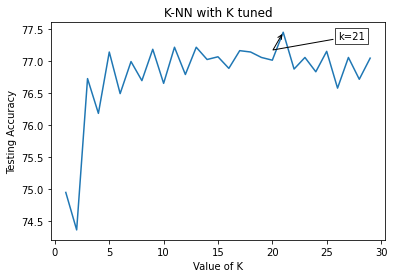

********************************
********** AdaBoost **********
Accuracy Report for n =  195
Confusion Matrix: 
 [[1677  329]
 [ 369 1638]]
Accuracy:  82.60652878146026
Report:
               precision    recall  f1-score   support

           g       0.83      0.82      0.82      2007
           h       0.82      0.84      0.83      2006

    accuracy                           0.83      4013
   macro avg       0.83      0.83      0.83      4013
weighted avg       0.83      0.83      0.83      4013



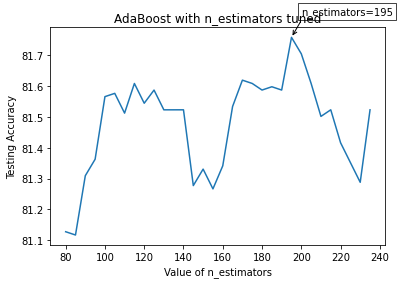

********************************
********** RandomForest **********
Accuracy Report for n =  185
Confusion Matrix: 
 [[1676  330]
 [ 264 1743]]
Accuracy:  85.19810615499627
Report:
               precision    recall  f1-score   support

           g       0.84      0.87      0.85      2007
           h       0.86      0.84      0.85      2006

    accuracy                           0.85      4013
   macro avg       0.85      0.85      0.85      4013
weighted avg       0.85      0.85      0.85      4013



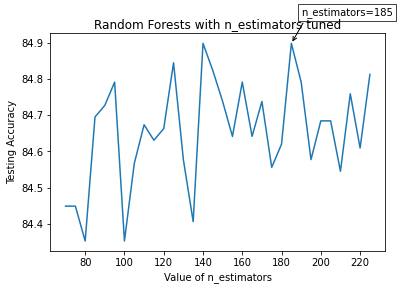

********************************


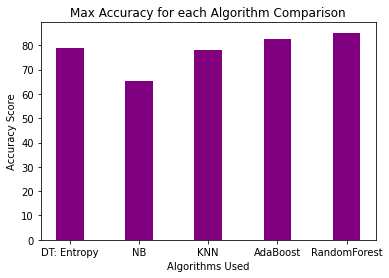

In [ ]:
if __name__ == "__main__":
    magic_dataset = read()
    magic_dataset = balance(magic_dataset)
    x_train, x_test, y_train, y_test = split(magic_dataset)
    decision_tree(x_train, x_test, y_train, y_test)
    naive_bayes(x_train, x_test, y_train, y_test)
    knn(x_train, x_test, y_train, y_test)
    AdaBoost(x_train, x_test, y_train, y_test)
    RandomForest(x_train, x_test, y_train, y_test)
    plot_max()